# SAp CTA data pipeline XPs

## Import directives

In [3]:
%matplotlib inline

import math
import numpy as np
import pandas as pd

#import common_functions as common

## TODO

### Top priority

- *TC ref.* vs *WT ref.* on $\Delta_\psi$:
    - plot the ratio of the two histograms
    - set bin size to 0.1°
    - check the gain ratio in the first bin: how much do we increase the number of events reconstructed with a shower angle precision less than 0.1°
- Plot *Epsilon_2 . npe* vs *npe*
- *Perpendicular Hit Distribution*:
    - plot the ratio of the two histograms (superposed with the two compared histograms but on a different Y axis)
- Refaire l'histogramme 2D $\mathcal{E}_{\text{energy}}$ vs *NPE* with the ``--kill-island`` option

### Misc

* Howto make (personalized) Reveal.js slides from this notebook: https://forum.poppy-project.org/t/utiliser-jupyter-pour-des-presentations-etape-par-etape-use-jupyter-to-present-step-by-step/2271/2

## Pandas test...

In [ ]:
gam = pd.read_csv("all_gamma_2017_01_25.csv").groupby('JSON input file')
gam['e_shape'].plot.hist(alpha=0.2, bins=100, legend=True)

In [ ]:
%run ./utils/plot_image_in_meter.py testset/gamma/jeanluc/run1001.simtel.gz_TEL001_EV131903.fits

## ASTRI mini-array configuration


- 38 telescopes:
    - 33 ASTRI telescopes
    - 5 FlashCam telescopes
- Events:
    - 40204 $\gamma$-rays
    - 7580 protons
- $\gamma$-rays and protons are stored in separate files


![image](./figs/astri_mini_array_labelled.png)

### ASTRI telescopes

- Telescopes 1 to 33
- 2368 (rectangular) pixels
- Optical focal length: 2.15m
- Pixel size: ~7.13mm x ~7.13mm

![image](./figs/geom_4_astri.png)

<img src="./figs/astri_mini_array_astri.png" width="60%">

### ASTRI telescopes - cropped images

![image](./figs/geom_4_astri_crop3.svg)

### FlashCam telescopes

- Telescopes 34 to 38
- 1764 (hexagonal) pixels
- Optical focal length: 16.0m

![image](./figs/geom_3_flashcam.png)

### FlashCam telescopes

<img src="./figs/astri_mini_array_flashcam.png" width="60%">

## Toolchain

### Toolchain overview

![image](./figs/workflow.svg)

- This is an overview of the toolchain
- We work with montecarlo simulations that give us simtel files
- I extract all images contained in these files into FITS files
- I use these FITS files as input of my image cleaning library
- It generate JSON files that can be converted to CSV or FITS

- Data: monte-carlo simulation
- Simulation setup: ASTRI mini-array (for convenience)
- Software:
    - "Offline" preprocessing (simtel to FITS)
        - https://github.com/jdhp-sap/sap-cta-data-pipeline/blob/master/utils/simtel_to_fits_astri.py
    - Image cleaning and benchmark
        - https://github.com/jdhp-sap/sap-cta-data-pipeline/blob/master/datapipe/denoising/wavelets_mrfilter.py
    - Required libraries
        - ctapipe: https://github.com/cta-observatory/ctapipe
        - pyhessio: https://github.com/cta-observatory/pyhessio
        - ISAP v3.1 http://www.cosmostat.org/wp-content/uploads/2014/12/ISAP_V3.1.tgz (see http://www.cosmostat.org/software/isap/)
        - Tino's scripts for reconstruction: https://github.com/tino-michael/tino_cta

## Image cleaning guidelines

For detailed procedure, see:

https://github.com/jdhp-sap/sap-cta-data-pipeline#image-cleaning-guidelines

### Step 1: Make data

Extract images from Simtel files, crop them, convert them to “regular” 2D
images and write them into fits files (one fits file per image with the ADC
signal in HDU0 and the photoelectron signal in HDU1):

1. clone http://github.com/jdhp-sap/snippets
2. check snippets/ctapipe/extract_and_crop_simtel_images.py on lines 64 and 66, these lines may need to be fixed
3. in ``snippets/ctapipe`` run:

    ./extract_crop_and_plot_all_astri_images.sh ASTRI_SIMTEL_FILE

Step 1.3 generate a lot of fits files in your current directory ; its execution
may be long (up to several hours) as the script is not optimized at all and
many instructions are redundant (but this is not a big deal because you only
need to run it once to generate your input files).

### Step 2: Install the wavelet library

Install mr_transform (the cosmostat wavelet transform tool):

1. download http://www.cosmostat.org/wp-content/uploads/2014/12/ISAP_V3.1.tgz (see http://www.cosmostat.org/software/isap/)
2. unzip this archive, go to the “sparse2d” directory and compile the sparse2d library. It should generate an executable named “mr_transform”:

```
tar -xzvf ISAP_V3.1.tgz
cd ISAP_V3.1/cxx
tar -xzvf sparse2d_V1.1.tgz
cd sparse2d
compile the content of this directory
```

### Step 3: Clean images generated in step 1

1. clone and install http://github.com/jdhp-sap/data-pipeline-standalone-scripts (see https://github.com/jdhp-sap/data-pipeline-standalone-scripts#installation)
2. to clean one fits file (see for instance run_experiments.sh):
    - with Tailcut : in data-pipeline-standalone-scripts, run ./datapipe/denoising/tailcut.py -T 0.75 -t 0.5 FITS_FILE (-T = max threshold, -t = min threshold, use the -h option to see command usage)
    - with FFT : in data-pipeline-standalone-scripts, run ./datapipe/denoising/fft.py -s -t 0.02 FITS_FILE (-t = threshold in the Fourier space, use the -h option to see command usage)
    - with Wavelets : in data-pipeline-standalone-scripts, run ./datapipe/denoising/wavelets_mrtrransform.py FITS_FILE (use the -h option to see command usage)
3. instead of the step 3.2, the “benchmark mode” can be set to clean images and assess cleaning algorithms (it’s still a bit experimental) : use the same instructions than for step 3.2 with the additional option “-b 1” in each command (and put several fits files in input e.g. “*.fits”)

### Step 4: Plot results

Optionally, plot some stats about scores: in data-pipeline-standalone-scripts/utils, use the plot_score_*.py scripts on the JSON files generated in step 3.3 (use the -h option to see command usage)


## Setup

- ASTRI mini-array (calibrated data)
- Telescopes 1 to 33 only (ASTRI)

### MC simulations

#### Gamma

Number of events per simtel files:

| File                       | Num. events |
| -------------------------- |:-----------:|
| *gamma/run_1001.simtel.gz* | 4461        |
|  gamma/run_1002.simtel.gz  | 4567        |
|  gamma/run_1003.simtel.gz  | 4425        |
|  gamma/run_1004.simtel.gz  | 4401        |
|  gamma/run_1005.simtel.gz  | 4451        |
|  gamma/run_1006.simtel.gz  | 4451        |
|  gamma/run_1007.simtel.gz  | 4614        |
|  gamma/run_1008.simtel.gz  | 4423        |
|  gamma/run_1009.simtel.gz  | 4411        |

#### Proton

Number of events per simtel files:

| File                       | Num. events |
| -------------------------- |:-----------:|
| proton/run_10000.simtel.gz | 747         |
| proton/run_10001.simtel.gz | 680         |
| proton/run_10002.simtel.gz | 763         |
| proton/run_10003.simtel.gz | 792         |
| proton/run_10004.simtel.gz | 763         |
| proton/run_10005.simtel.gz | 776         |
| proton/run_10006.simtel.gz | 738         |
| proton/run_10007.simtel.gz | 749         |
| proton/run_10008.simtel.gz | 760         |
| proton/run_10009.simtel.gz | 812         |

### Subset of events used for experiments

Only one simtel file is used for presented results:

```
sapcta:/dsm/manip/cta/DATA/astri\_mini\_array/gamma/run1001.simtel.gz
```

FITS files made form this Simtel file are stored in:

```
sapcta:/dsm/manip/cta/DATA/astri\_mini\_array/fits/gamma/
```

This subset contains:
- 4461 events from 118 GeV to 256 TeV (Gamma events only)
- 14899 images

### Calibration

TODO...

### Cleaning algorithms

#### Tailcut

Ctapipe's implementation with:

- high threshold set to 10 PE
- low threshold set to 5 PE

Reference: https://arxiv.org/abs/astro-ph/0607333

#### Wavelets

- Cosmostat's Sparce2D (mr\_filter) "b-spline" wavelet transform
- Parameters detailled later

## Results

Results are stored in the followed directory (on SAPCTA) in JSON files (structured results) and in CSV and FITS files (flattened results for Glueviz for instance):

```
sapcta:/dsm/manip/cta/xp_jd/2016_12_13/
```

## Metrics

### $\mathcal{E}_{\text{shape}}$

$$
\mathcal{E}_{\text{shape}}(\hat{\boldsymbol{S}}, \boldsymbol{S}^*) = \left\langle \text{abs} \left( \frac{\hat{\boldsymbol{S}}}{\sum_i \hat{\boldsymbol{S}}_i} - \frac{\boldsymbol{S}^*}{\sum_i \boldsymbol{S}^*_i} \right) \right\rangle
$$

with:

- $\hat{\boldsymbol{S}}$ the algorithm's output image (i.e. the *cleaned* image);
- $\boldsymbol{S}^*$ the reference image (i.e. the *clean* image);
- $\langle \boldsymbol{S} \rangle$ the average of matrix $\boldsymbol{S}$.
- $\mathcal{E}_{\text{shape}}(\cdot, \cdot) \in \left[ 0, \frac{2}{\mbox{num_pixels}} \right]$

#### Theoritical maximum (wrost) value

$$
\frac{2}{\mbox{num_pixels}} = \frac{2}{40^2} = 0.00125
$$

Worst case is when no pixels are in common between the two images.
Because of the normalisation, the sum of all pixels value on each image is 1.
Thus the worst possible value is $\frac{1 + 1}{\mbox{num_pixels}}$

##### Example for images with 4 pixels

|   |   |
| - | - |
| 0 | 1 |
| 0 | 0 |

-

|   |   |
| - | - |
| 0 | 1 |
| 0 | 0 |

= 

|   |   |
| - | - |
| 0 | 1 |
| 1 | 0 |

=> mean = 0.5 = $\frac{2}{\mbox{num_pixels}}$

--

##### Another image with 4 pixels

|     |     |
| --- | --- |
| 0.5 | 0   |
| 0   | 0.5 |

-

|     |     |
| --- | --- |
| 0   | 0.5 |
| 0.5 | 0   |

= 

|     |     |
| --- | --- |
| 0.5 | 0.5 |
| 0.5 | 0.5 |

=> mean = 0.5 = $\frac{2}{\mbox{num_pixels}}$

--

##### Another image with 4 pixels

|      |      |
| ---- | ---- |
| 0.75 | 0    |
| 0    | 0.25 |

-

|      |      |
| ---- | ---- |
| 0    | 0.25 |
| 0.75 | 0    |

= 

|      |      |
| ---- | ---- |
| 0.75 | 0.25 |
| 0.75 | 0.25 |

=> mean = 0.5 = $\frac{2}{\mbox{num_pixels}}$

--

##### For images with 9 pixels

|   |   |   |
| - | - | - |
| 0 | 0 | 1 |
| 0 | 0 | 0 |
| 0 | 0 | 0 |

-

|   |   |   |
| - | - | - |
| 0 | 0 | 0 |
| 0 | 0 | 0 |
| 1 | 0 | 0 |

= 

|   |   |   |
| - | - | - |
| 0 | 0 | 1 |
| 0 | 0 | 0 |
| 1 | 0 | 0 |

=> mean = 2/9 = $\frac{2}{\mbox{num_pixels}}$

## Metrics

### $\mathcal{E}_{\text{energy}}$ (relative total counts difference)

$$
\mathcal{E}_{\text{energy}}(\hat{\boldsymbol{S}}, \boldsymbol{S}^*) = \frac{ \text{abs} \left( \sum_i \hat{\boldsymbol{S}}_i - \sum_i \boldsymbol{S}^*_i \right) }{ \sum_i \boldsymbol{S}^*_i }
$$

with:

- $\hat{\boldsymbol{S}}$ the algorithm's output image (i.e. the *cleaned* image);
- $\boldsymbol{S}^*$ the reference image (i.e. the *clean* image).

## Input data study

### Total number of photoelectrons (NPE) per image

### Wavelets "reference" (the one presented in Bologna)

Full ``mr_filter`` setup:

- Wavelet function: bspline wavelet transform "a trous" algorithm (``-t2``)
- Coef. detection method: K-SigmaNoise Threshold (``-C1``)
- Type of filtering: Hard K-Sigma Thresholding (``-f1``)
- K-Sigma noise threshold: 3 (``-s3``)
- Noise model: Poisson noise + Gaussian noise (``-m3``)
- Number of scales: 4 (``-n4``)
- Suppress isolated pixels: yes (``-k``)
- Suppress last scale: yes (``-K``)

#### Epsilon shape

![image](./figs/tc_vs_wt_ref_eshape.png)

~~

- We compare:
    - this wavelet "reference" (in green)
    - with the Tailcut reference (in blue)
- ... according to the "Epsilon shape" metric.
- The lower the better.
- Tailcut has more "good" results (on left of each histogram).
- But Wavelet has less "bad" results (on right of each histogram) at medium energy ranges (1 TeV to 100 TeV).

#### Epsilon energy

![image](./figs/tc_vs_wt_ref_eenergy.png)

~~

- The same with the "Epsilon energy" metric
- Again, the lower the better
- Tailcut has better results

### Wavelets with FDR threshold ("-C2" option)

Full mr_filter setup:
```none
Wavelet function: bspline wavelet transform "a trous" algorithm (-t2)
Coef. detection method: FDR (-C2)
Type of filtering: Hard K-Sigma Thresholding (-f1)
Noise model: Poisson noise + Gaussian noise (-m3)
Number of scales: 4 (-n4)
Suppress isolated pixels: yes (-k)
Suppress last scale: yes (-K)
```

~~

- Among the parameters I tested, I show this one (recomanded by Sandrine)
- FDR means False Discovery Rate,
- it's an adaptive methode to discover the best threshold value for each plane

#### Epsilon shape

![image](./figs/wt_ref_vs_wt_c2_eshape.png)

~~

- Here we compare:
    - this wavelet "reference" (in blue)
    - with the wavelet using FDR (in green)
- according to the "Epsilon shape" metric
- We have slightly better results without FDR than with FDR

#### Epsilon energy

![image](./figs/wt_ref_vs_wt_c2_eenergy.png)

#### Examples

- TODO: add image examples...

#### Conclusion

FDR doesn't seem to be a good idea for our setup

### Hillas parameters metric $\Delta_{\theta}$

#### Definition

Compute the score of *cleaned image* regarding *reference image* with the Hillas
parameter theta:

$$\Delta_{\theta} = \theta_\text{ref} - \theta_\text{cleaned}$$

#### Wavelets "reference"

![image](./figs/tc_vs_wt_ref_theta.png)

~~

- Here we compare Tailcut reference and Wavelet "reference"
- with this new metric
- The more we have counts around 0, 180 and -180 the better we are
- The less we have counts around 90 and -90 the better we are
- Results: Tailcut has better results than Wavelet reference

#### Wavelets with FDR threshold ("-C2" option)

![image](./figs/tc_vs_wt_c2_theta.png)

~~

- Results: Tailcut has better results than Wavelet with FDR

#### Conclusion

Tailcut has better results than Wavelet reference and Wavelet with FDR

~~

But we will see later that this conclusion will be reversed with an extra option

### Kill isolated pixels

mr_filter's "-k" option doesn't work properly

#### Failure example

<img src="./figs/kill_isolated_pixels/ev458109_tel1.png" width="85%">

<img src="./figs/kill_isolated_pixels/ev64302_tel1.png" width="85%">

<img src="./figs/kill_isolated_pixels/ev481109_tel1_log.png" width="85%">

#### Fix

To fix that, I added a function that removes remaining isolated pixels (based on scipy like Fabio did).

This function is activated by the "--kill-isolated-pixels" option in

```
*./datapipe/denoising/wavelets\_mrfilter.py*
```

#### Fixed example

<img src="./figs/kill_isolated_pixels/ev458109_tel1_kill.png" width="85%">
<img src="./figs/kill_isolated_pixels/ev458109_tel1.png" width="85%">

<img src="./figs/kill_isolated_pixels/ev64302_tel1_kill.png" width="85%">
<img src="./figs/kill_isolated_pixels/ev64302_tel1.png" width="85%">

<img src="./figs/kill_isolated_pixels/ev481109_tel1_log_kill.png" width="85%">
<img src="./figs/kill_isolated_pixels/ev481109_tel1_log.png" width="85%">

#### Results

![image](./figs/wt_ref_vs_wt_kill_eshape.png)

- This new option slightly reduce the number of bad results with epsilon shape

##### Impact on results (VS WT ref.)

![image](./figs/wt_ref_vs_wt_kill_eenergy.png)

~~

- Strangely this option has a negative impact on results according to epsilon energy...

##### Impact on results (VS WT ref.)

![image](./figs/wt_ref_vs_wt_kill_theta.png)

~~

- ... but it has a very positive impact on results according to Hillas theta metric

##### Impact on results (VS WT with FDR threshold)

![image](./figs/wt_ref_vs_wt_c2_kill_eshape.png)

~~

- We have the same conclusion with FDR than with the wavelet reference:
- the new option slightly reduce the number of bad results with epsilon shape...

##### Impact on results (VS WT with FDR threshold)

![image](./figs/wt_ref_vs_wt_c2_kill_eenergy.png)

~~

- ... and again it has a negative impact on results according to epsilon energy...

##### Impact on results (VS WT with FDR threshold)

![image](./figs/wt_ref_vs_wt_c2_kill_theta.png)

~~

- ... but it has a very positive impact on results according to Hillas theta metric

##### Impact on results (VS  Tailcut)

![image](./figs/tc_vs_wt_kill_eshape.png)

~~

- When we compare with Tailcut,
- the new option doesn't change results according to epsilon shape metric: Tailcut is still better

##### Impact on results (VS  Tailcut)

![image](./figs/tc_vs_wt_kill_eenergy.png)

~~

- ditto for epsilon energy metric: Tailcut is still better

##### Impact on results (VS  Tailcut)

![image](./figs/tc_vs_wt_kill_theta.png)

~~

- but Tailcut is beaten according to Hillas Theta metric!

##### Conclusion

This fix ("--kill-isolated-pixels"):

- has very little impact with $\mathcal{E}_{\text{shape}}$
- has a negative impact with $\mathcal{E}_{\text{energy}}$
- gives clearly better results with $\Delta_{\theta}$
- gives clearly better results by eye

**According to $\Delta_{\theta}$, Wavelet transform
gives better results than Tailcut with this fix!** (especially between 1 and 10 TeV)

This partly explains why results are bad with pixel based metrics but are good
with reconstruction and high level physics metrics (as Tino used a similar
method in his experiments)

### Is FDR option better according to $\Delta_{\theta}$ ?

![image](./figs/wt_ref_vs_wt_c2_theta.png)

No...

### Hillas parameters metric revisited ($\Delta_{\theta}2$)

In this case, "--kill-isolated-pixels" is applied to the reference
images (see next section).

##### Impact on results (VS WT ref. + Kill isolated pixels)

![image](./figs/wt_ref_vs_wt_kill_theta2.png)
![image](./figs/wt_ref_vs_wt_kill_theta.png)

##### Impact on results (VS WT with FDR threshold + Kill isolated pixels)

![image](./figs/wt_ref_vs_wt_c2_kill_theta2.png)
![image](./figs/wt_ref_vs_wt_c2_kill_theta.png)

##### Wavelets "reference"

![image](./figs/tc_vs_wt_ref_theta2.png)
![image](./figs/tc_vs_wt_ref_theta.png)

##### Wavelets with FDR threshold ("-C2" option)

![image](./figs/tc_vs_wt_c2_theta2.png)
![image](./figs/tc_vs_wt_c2_theta.png)

##### Impact on results (VS  Tailcut + Kill isolated pixels)

![image](./figs/tc_vs_wt_kill_theta2.png)
![image](./figs/tc_vs_wt_kill_theta.png)

#### Conclusion

Results are roughly the same with $\Delta_{\theta}2$ than with $\Delta_{\theta}$

### Number of dropped images

Images returned by cleaning methods are dropped when they are completely empty
(to avoid division by zero in some metrics).

Total number of input images for presented results: 14899

```
find ~/astri_data/fits/gamma/ -type f -name "*.fits" 2> /dev/null | wc -l
cut -s -d , -f 1 score_gamma_all.csv | grep "FILE_NAME.json" | wc -l
```

| File                                               | Num. images | Dropped images |
| -------------------------------------------------- | -----------:| --------------:|
| score_gamma_all_tailcut_ref.json                   | 14528       | 371            |
| score_gamma_all_wavelets_mrfilter_ref.json         | 14894       | 5              |
| score_gamma_all_wavelets_mrfilter_kill.json        | 14894       | 5              |
| score_gamma_all_wavelets_mrfilter_c2.json          | 14639       | 260            |
| score_gamma_all_wavelets_mrfilter_c2_kill.json     | 14639       | 260            |
| score_gamma_all_wavelets_mrfilter_kill_offset.json | 12352       | 2547           |


## Logarithmic and square root images

When applying an offset (10 PE) and a logarithmic (or square root)
transformation on the input image image (and the inverses
transformations after cleaning on output images).


## Logarithmic and square root images
### Example 1

<img src="./figs/lip1.svg" width="100%">


## Logarithmic and square root images
### Example 2

<img src="./figs/lip2.svg" width="100%">


## Logarithmic and square root images
### Conclusion

As is, it doesn't work


## Consistency with Tino's results

### On small set of images

Tested on a set of 5 images (event \#100):

    Tel 9:
        E_energy TC: 0.23361876971918988
        E_energy WT: 0.34390493542761413

    Tel 14:
        E_energy TC: 0.18085652413547679
        E_energy WT: 0.22658406662684616

    Tel 17:
        E_energy TC: 0.13956736034362127
        E_energy WT: 0.24204471371821221

    Tel 25:
        E_energy TC: 0.25076103102349279
        E_energy WT: 0.4738171241645302

Data:

```
~/git/pub/jdhp-sap/sap-cta-data-pipeline/testset/gamma/ev100
```

Params:

```
mr_filter -K -k -C1 -m3 -s3 -n4
```

Resluts are exaclty the same in tino\_cta and sap-cta-data-pipeline.

But...


### On all images

![image](./figs/wt_ref_jd.png)

![image](./figs/wt_ref_tino.png)

## Perpendicular hit distribution

## Noise (NSB, electronic noise, ...)

Here is is plotted:

```
input_image - reference_image
```

### Noise histogram for telescope 1

Parsing ./testset/gamma/tel1/
0.21% (1/475)
1.26% (6/475)
2.32% (11/475)
3.37% (16/475)
4.42% (21/475)
5.47% (26/475)
6.53% (31/475)
7.58% (36/475)
8.63% (41/475)
9.68% (46/475)
10.74% (51/475)
11.79% (56/475)
12.84% (61/475)
13.89% (66/475)
14.95% (71/475)
16.00% (76/475)
17.05% (81/475)
18.11% (86/475)
19.16% (91/475)
20.21% (96/475)
21.26% (101/475)
22.32% (106/475)
23.37% (111/475)
24.42% (116/475)
25.47% (121/475)
26.53% (126/475)
27.58% (131/475)
28.63% (136/475)
29.68% (141/475)
30.74% (146/475)
31.79% (151/475)
32.84% (156/475)
33.89% (161/475)
34.95% (166/475)
36.00% (171/475)
37.05% (176/475)
38.11% (181/475)
39.16% (186/475)
40.21% (191/475)
41.26% (196/475)
42.32% (201/475)
43.37% (206/475)
44.42% (211/475)
45.47% (216/475)
46.53% (221/475)
47.58% (226/475)
48.63% (231/475)
49.68% (236/475)
50.74% (241/475)
51.79% (246/475)
52.84% (251/475)
53.89% (256/475)
54.95% (261/475)
56.00% (266/475)
57.05% (271/475)
58.11% (276/475)
59.16% (281/475)
60.21% (286/475)
61.26% (291/475)

/Users/jdecock/anaconda/envs/cta/lib/python3.5/site-packages/matplotlib/axes/_axes.py:519: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


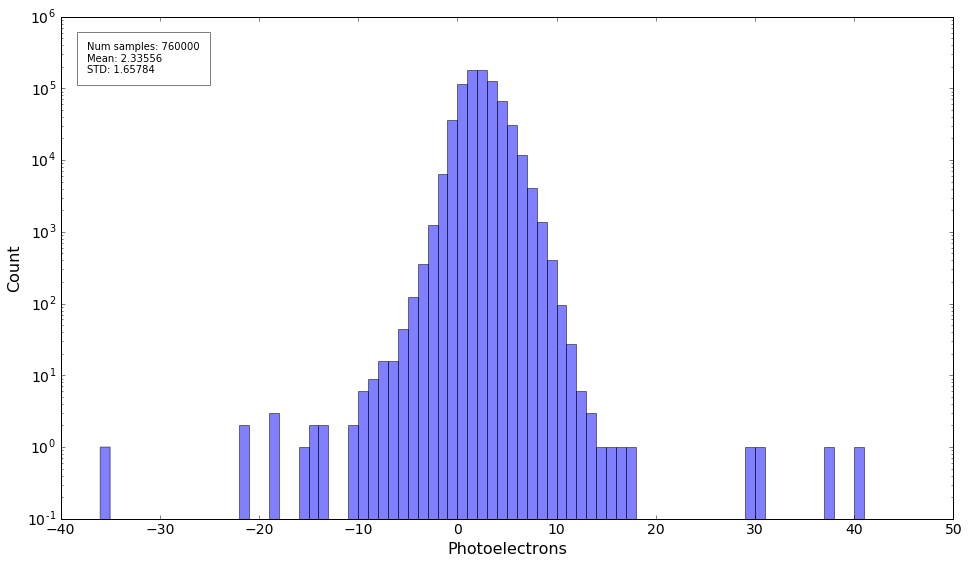

In [2]:
%run ./utils/plot_noise_histogram.py --notebook --logy ./testset/gamma/tel1/

### Noise histogram for telescope 2

In [ ]:
%run ./utils/plot_noise_histogram.py --quiet --output ./noise_histogram_tel2.png --logy ./testset/gamma/tel2/

![image](./noise_histogram_tel2.png)

## Noise histogram for some events

![image](./figs/noise_histogram_ev507_tel1.png)

--

## Noise histogram for some events

![image](./figs/noise_histogram_ev1909_tel1.png)

--

## Noise histogram for some events

![image](./figs/noise_histogram_ev2403_tel1.png)


## Noise

Not a friendly distribution for Sparce2D

~~

Not a friendly distribution for Cosmostat tools


## Default wavelet implemetation
### Bspline "a trou"


## Default wavelet implemetation
### *mr_transform()* function

Implemented in *~/bin/isap/cxx/sparse2d/src/libsparse2d/MR_Trans.cc*

```cpp
static void mr_transform (Ifloat &Image,
                          MultiResol &MR_Transf,
                          Bool EdgeLineTransform,
                          type_border Border,
                          Bool Details) {
    // [...]
    MR_Transf.band(0) = Image;
    for (s = 0; s < Nbr_Plan -1; s++) {
       smooth_bspline (MR_Transf.band(s),MR_Transf.band(s+1),Border,s);
       MR_Transf.band(s) -= MR_Transf.band(s+1);
    }
    // [...]
}
```

--

## Default wavelet implemetation
### Bspline "a trou"

<img src="./figs/wt_bspline.tex.svg" width="90%">

*convolve()* function is implemented in *smooth_bspline()* in sparce2d


## Default wavelet implemetation
### *smooth_bspline()* function

Implemented in *isap/cxx/sparse2d/src/libsparse2d/IM_Smooth.cc*

```cpp
void smooth_bspline (const Ifloat & Im_in,
                     Ifloat &Im_out,
                     type_border Type, int Step_trou) {
    int Nl = Im_in.nl();
    int Nc = Im_in.nc();
    int i,j,Step;
    float Coeff_h0 = 3. / 8.;
    float Coeff_h1 = 1. / 4.;
    float Coeff_h2 = 1. / 16.;
    Ifloat Buff(Nl,Nc,"Buff smooth_bspline");

    Step = (int)(pow((double)2., (double) Step_trou) + 0.5);

    for (i = 0; i < Nl; i ++)
    for (j = 0; j < Nc; j ++)
       Buff(i,j) = Coeff_h0 *    Im_in(i,j)
                 + Coeff_h1 * (  Im_in (i, j-Step, Type) 
                               + Im_in (i, j+Step, Type)) 
                 + Coeff_h2 * (  Im_in (i, j-2*Step, Type) 
                               + Im_in (i, j+2*Step, Type));

    for (i = 0; i < Nl; i ++)
    for (j = 0; j < Nc; j ++)
       Im_out(i,j) = Coeff_h0 *    Buff(i,j)
                   + Coeff_h1 * (  Buff (i-Step, j, Type) 
                                 + Buff (i+Step, j, Type)) 
                   + Coeff_h2 * (  Buff (i-2*Step, j, Type) 
                                 + Buff (i+2*Step, j, Type));
}
```


## Default wavelet implemetation

Good for:
- Kai tests (wrapper)
- Hexagonal shape cameras
- Logarithmic image processing studies

~~

The implementation is simpler than what I thought
and it is conceptually easy to adapt it to hexagonal pixel shapes cameras

--

<img src="./figs/hexagonal_grid.png" width="50%">

--

<img src="./figs/hexagonal_grid_2.gif" width="70%">


### Loss of energy on very high energy images (> 10000 pe)

#### Problem description

On images with NPE > 10000, we lose a lot of energy i.e. on $\mathcal{E}_{\text{energy}}$ 2D histograms, performance of cleaning algorithms decrease strongly at high NPE.

Yeah... but actualy Tailcut has the same problem.

#### Conclusion [2017-02-01]

Actually, the cut on very high pixel values is already done within calibrated **input** images...
Thus of course, no cleaning algorithm can retrive them.

The electronic simply saturates (~"the ADC has a 11 bits buffer"~) and there is nothing we can do about this...
We should drop those images.